# Scénario OpenClassrooms
Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation.
Des relevés minutieux ont été effectués par les agents de la ville en 2016. Voici les données et leur source. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez **tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées.**

Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.

Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :

Réaliser une courte analyse exploratoire.
Tester différents modèles de prédiction afin de répondre au mieux à la problématique.
Avant de quitter la salle de brief, Douglas, le project lead, vous donne quelques pistes et erreurs à éviter :

Douglas : L’objectif est de te passer des relevés de consommation annuels futurs (attention à la fuite de données). Nous ferons de toute façon pour tout nouveau bâtiment un premier relevé de référence la première année, donc rien ne t'interdit d’en déduire des variables structurelles aux bâtiments, par exemple la nature et proportions des sources d’énergie utilisées.. 

Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée.

# Missions
    - Analyse exploratoire
    - Variables : sélection, passage au log ?
    - Adresse comme simple prédicteur ?
    - Prédiction émission CO2 et consommation électrique totale des bâtiments NON DESTINÉS à HABITATION
    - Évaluer ENERGY STAR Score : intérêt, limite
    - ML , hyperparamètre 

In [34]:
#!conda install -c conda-forge dataprep

^C


In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme(style="darkgrid")

In [2]:
data = pd.read_csv('2016_Building_Energy_Benchmarking.csv')

In [3]:
data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


# Analyse exploratoire

In [48]:
for col in data.columns:
    print(col)
    print(data[col].nunique())
    
    

OSEBuildingID
3376
DataYear
1
BuildingType
8
PrimaryPropertyType
24
PropertyName
3362
Address
3354
City
1
State
1
ZipCode
55
TaxParcelIdentificationNumber
3268
CouncilDistrictCode
7
Neighborhood
19
Latitude
2876
Longitude
2656
YearBuilt
113
NumberofBuildings
17
NumberofFloors
50
PropertyGFATotal
3195
PropertyGFAParking
496
PropertyGFABuilding(s)
3193
ListOfAllPropertyUseTypes
466
LargestPropertyUseType
56
LargestPropertyUseTypeGFA
3122
SecondLargestPropertyUseType
50
SecondLargestPropertyUseTypeGFA
1352
ThirdLargestPropertyUseType
44
ThirdLargestPropertyUseTypeGFA
501
YearsENERGYSTARCertified
65
ENERGYSTARScore
100
SiteEUI(kBtu/sf)
1085
SiteEUIWN(kBtu/sf)
1105
SourceEUI(kBtu/sf)
1648
SourceEUIWN(kBtu/sf)
1694
SiteEnergyUse(kBtu)
3354
SiteEnergyUseWN(kBtu)
3341
SteamUse(kBtu)
131
Electricity(kWh)
3352
Electricity(kBtu)
3351
NaturalGas(therms)
2109
NaturalGas(kBtu)
2109
DefaultData
2
Comments
0
ComplianceStatus
4
Outlier
2
TotalGHGEmissions
2818
GHGEmissionsIntensity
511


In [49]:
data.ComplianceStatus.unique()

array(['Compliant', 'Error - Correct Default Data', 'Missing Data',
       'Non-Compliant'], dtype=object)

In [50]:
data.ZipCode.unique()

array([98101., 98121., 98104., 98154., 98118., 98105., 98112., 98125.,
       98109., 98070., 98108., 98199., 98115., 98107., 98144., 98103.,
       98119., 98136., 98122., 98126., 98133., 98146., 98033., 98106.,
       98111., 98134., 98117., 98116., 98191., 98164., 98195., 98185.,
       98181., 98102., 98168., 98155., 98006., 98124., 98053., 98012.,
       98013., 98028., 98178., 98114., 98127., 98165., 98011., 98198.,
       98113., 98040., 98204., 98177., 98020., 98272., 98145.,    nan])

In [13]:
data.Outlier.unique()

array([nan, 'High outlier', 'Low outlier'], dtype=object)

In [14]:
data.Outlier.value_counts()

Low outlier     23
High outlier     9
Name: Outlier, dtype: int64

In [36]:
data.describe().round()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,...,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,3376.0,3376.0,3360.0,3376.0,3376.0,3376.0,3376.0,3368.0,3376.0,3376.0,...,3371.0,3370.0,3367.0,3367.0,3367.0,3367.0,3367.0,0.0,3367.0,3367.0
mean,21209.0,2016.0,98117.0,4.0,48.0,-122.0,1969.0,1.0,5.0,94834.0,...,5403667.0,5276726.0,274596.0,1086639.0,3707612.0,13685.0,1368505.0,NaN,120.0,1.0
std,12224.0,0.0,19.0,2.0,0.0,0.0,33.0,2.0,5.0,218838.0,...,21610629.0,15938786.0,3912173.0,4352478.0,14850656.0,67098.0,6709781.0,NaN,539.0,2.0
min,1.0,2016.0,98006.0,1.0,47.0,-122.0,1900.0,0.0,0.0,11285.0,...,0.0,0.0,0.0,-33827.0,-115417.0,0.0,0.0,NaN,-1.0,-0.0
25%,19991.0,2016.0,98105.0,3.0,48.0,-122.0,1948.0,1.0,2.0,28487.0,...,925129.0,970182.0,0.0,187423.0,639487.0,0.0,0.0,NaN,9.0,0.0
50%,23112.0,2016.0,98115.0,4.0,48.0,-122.0,1975.0,1.0,4.0,44175.0,...,1803753.0,1904452.0,0.0,345130.0,1177583.0,3238.0,323754.0,NaN,34.0,1.0
75%,25994.0,2016.0,98122.0,7.0,48.0,-122.0,1997.0,1.0,5.0,90992.0,...,4222455.0,4381429.0,0.0,829318.0,2829632.0,11890.0,1189034.0,NaN,94.0,1.0
max,50226.0,2016.0,98272.0,7.0,48.0,-122.0,2015.0,111.0,99.0,9320156.0,...,873923712.0,471613856.0,134943456.0,192577488.0,657074389.0,2979090.0,297909000.0,NaN,16871.0,34.0


In [36]:
data.ZipCode.nunique()

55

<Figure size 720x720 with 0 Axes>

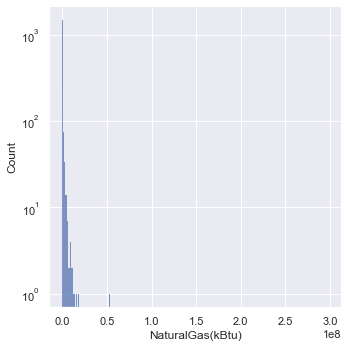

In [34]:
plt.figure(figsize=(10,10))
sns.displot(data=data,x='NaturalGas(kBtu)',log=True)

<Figure size 720x720 with 0 Axes>

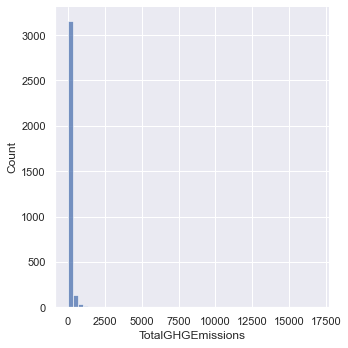

In [20]:
plt.figure(figsize=(10,10))
sns.displot(data=data,x='TotalGHGEmissions',bins=50)

In [16]:
np.log10(data['TotalGHGEmissions'])

C:\Users\arthk\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\arthk\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


0       2.397905
1       2.471086
2       3.319997
3       2.457019
4       2.703300
          ...   
3371    1.320977
3372    1.507451
3373    2.349355
3374    1.344589
3375    1.615634
Name: TotalGHGEmissions, Length: 3376, dtype: float64

## Valeurs manquantes

In [27]:
data.isna().mean().sort_values(ascending=False).head(15)

Comments                           1.000000
Outlier                            0.990521
YearsENERGYSTARCertified           0.964751
ThirdLargestPropertyUseType        0.823460
ThirdLargestPropertyUseTypeGFA     0.823460
SecondLargestPropertyUseType       0.502666
SecondLargestPropertyUseTypeGFA    0.502666
ENERGYSTARScore                    0.249704
LargestPropertyUseTypeGFA          0.005924
LargestPropertyUseType             0.005924
ZipCode                            0.004739
SourceEUI(kBtu/sf)                 0.002666
ListOfAllPropertyUseTypes          0.002666
TotalGHGEmissions                  0.002666
GHGEmissionsIntensity              0.002666
dtype: float64

## Variable Outlier ? 

In [5]:
data.loc[
    data['Outlier'].notnull()
]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
226,350,2016,NonResidential,Large Office,Second And Spring Building,1100 Second Avenue,Seattle,WA,98101.0,0942000045,...,1.166315e+07,39794668.0,16048.309570,1604831.0,False,NaN,Non-Compliant,High outlier,362.66,2.10
384,539,2016,NonResidential,Retail Store,University Center,4501 Roosevelt Way NE,Seattle,WA,98105.0,5335200380,...,9.348260e+04,318963.0,0.000000,0.0,False,NaN,Non-Compliant,Low outlier,2.22,0.03
448,608,2016,NonResidential,Large Office,411 1ST AVE S (ID608),411 1ST AVE S,Seattle,WA,98104.0,5247800200,...,4.715030e+05,1608768.0,3430.500488,343050.0,False,NaN,Non-Compliant,Low outlier,29.43,0.19
517,704,2016,NonResidential,Large Office,401 Elliott Ave West,401 Elliot Ave West,Seattle,WA,98119.0,7666202110,...,7.953454e+06,27137187.0,0.000000,0.0,False,NaN,Non-Compliant,High outlier,189.18,1.46
720,19708,2016,Multifamily HR (10+),High-Rise Multifamily,Bay Vista,2821 2nd Ave,Seattle,WA,98121.0,0586400000,...,6.265616e+05,2137828.0,2700.760010,270076.0,False,NaN,Non-Compliant,Low outlier,29.25,0.17
834,19934,2016,Multifamily LR (1-4),Low-Rise Multifamily,Belmont Lofts,231 Belmont Ave E,Seattle,WA,98102.0,0704600000,...,7.502090e+04,255971.0,0.000000,0.0,False,NaN,Non-Compliant,Low outlier,1.78,0.06
839,19967,2016,SPS-District K-12,K-12 School,Queen Anne Gym,1431 2nd Ave N,Seattle,WA,98109.0,0811000005,...,7.228240e+04,246628.0,1848.439575,184844.0,True,NaN,Error - Correct Default Data,Low outlier,11.54,0.32
962,20367,2016,Multifamily LR (1-4),Low-Rise Multifamily,City Lights on Harbor,2349 Harbor Ave. SW,Seattle,WA,98126.0,1595200000,...,2.058855e+05,702481.0,0.000000,0.0,False,NaN,Non-Compliant,Low outlier,4.90,0.07
1045,20617,2016,NonResidential,Retail Store,Seattle Habitat Store,21 S Nevada St,Seattle,WA,98134.0,1824049074,...,1.436250e+04,49005.0,964.640015,96464.0,True,NaN,Error - Correct Default Data,Low outlier,5.46,0.14
1229,21315,2016,NonResidential,Small- and Mid-Sized Office,1518 Fifith Ave,1520 Fifth Ave,Seattle,WA,98101.0,1975700135,...,7.064900e+03,24105.0,0.000000,0.0,False,NaN,Non-Compliant,Low outlier,0.17,0.00


Text(0.5, 1.0, 'Emissions par types de bâtiments')

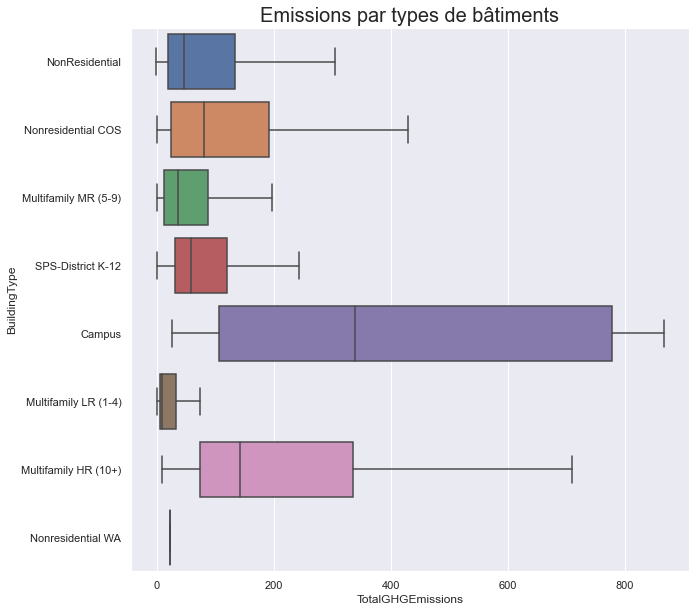

In [73]:
plt.figure(figsize=(10,10))
sns.boxplot(
    data=data, 
    y='BuildingType',
    x='TotalGHGEmissions',
    showfliers = False
    ).set_title("Emissions par types de bâtiments",
               fontdict={'size': 20}
               )

Text(0.5, 1.0, "Emissions par types d'activités")

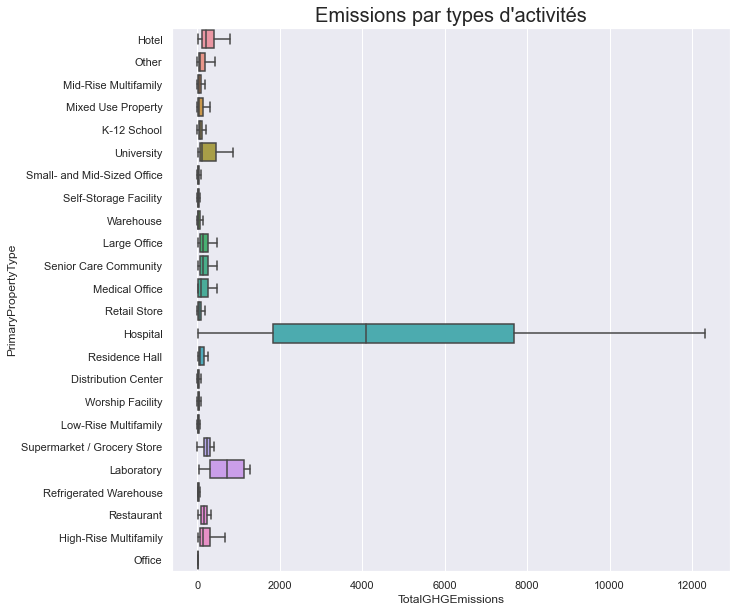

In [74]:
plt.figure(figsize=(10,10))
sns.boxplot(
    data=data, 
    y='PrimaryPropertyType',
    x='TotalGHGEmissions',
    showfliers = False

).set_title(
    "Emissions par types d'activités",
    fontdict={'size': 20}
)

Text(0.5, 1.0, "Emissions par types d'activités sans les Hopitaux")

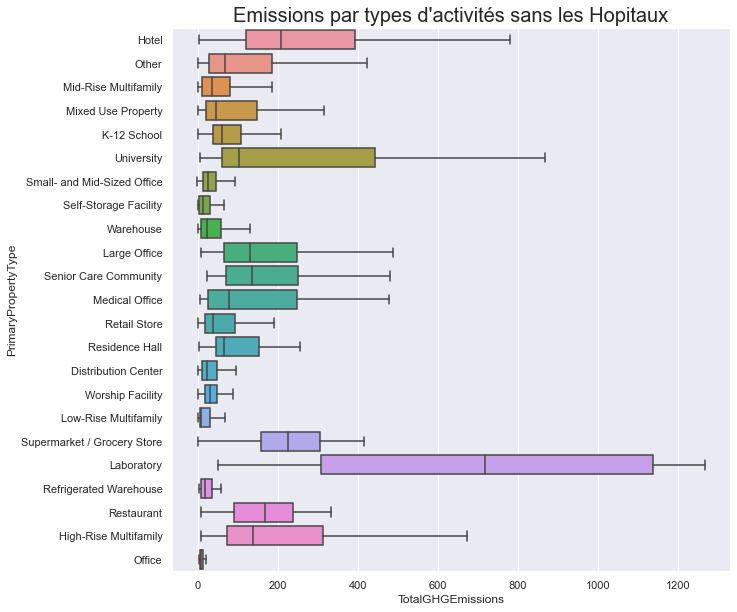

In [76]:
plt.figure(figsize=(10,10))
sns.boxplot(
    data=data.loc[
        data['PrimaryPropertyType'] != 'Hospital'
    ], 
    y='PrimaryPropertyType',
    x='TotalGHGEmissions',
    showfliers = False

).set_title(
    "Emissions par types d'activités sans les Hopitaux",
    fontdict={'size': 20}
)

Text(0.5, 1.0, 'Emissions par quartiers')

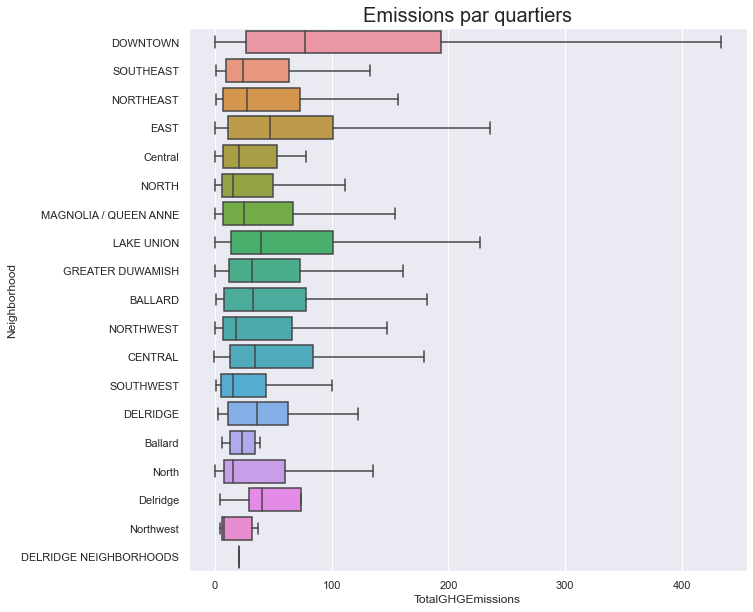

In [72]:
plt.figure(figsize=(10,10))
sns.boxplot(
    data=data, 
    y='Neighborhood',
    x='TotalGHGEmissions',
    showfliers = False
).set_title("Emissions par quartiers",
               fontdict={'size': 20}
               )

Text(0.5, 1.0, 'Emissions par années')

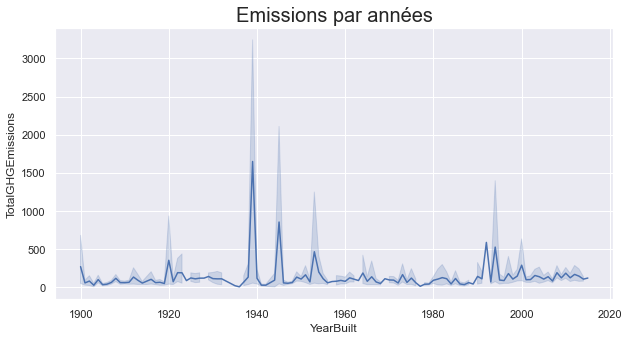

In [68]:
plt.figure(figsize=(10,5))
sns.lineplot(
    data=data, 
    y='TotalGHGEmissions',
    x='YearBuilt').set_title("Emissions par années",
               fontdict={'size': 20}
               )

> Émissions liées à l'activité : construction, secteur industriel. Période de la Seconde Guerre Mondiale et après guerre pic d'activité.

In [84]:
data[['TotalGHGEmissions','GHGEmissionsIntensity']].describe()

,TotalGHGEmissions,GHGEmissionsIntensity
count,3367.000000,3367.000000
mean,119.723971,1.175916
std,538.832227,1.821452
min,-0.800000,-0.020000
25%,9.495000,0.210000
50%,33.920000,0.610000
75%,93.940000,1.370000
max,16870.980000,34.090000


In [85]:
data[['TotalGHGEmissions','GHGEmissionsIntensity']].corr()

,TotalGHGEmissions,GHGEmissionsIntensity
TotalGHGEmissions,1.000000,0.470212
GHGEmissionsIntensity,0.470212,1.000000


In [87]:
data[['TotalGHGEmissions','NumberofBuildings']].corr()

,TotalGHGEmissions,NumberofBuildings
TotalGHGEmissions,1.000000,0.405261
NumberofBuildings,0.405261,1.000000


<AxesSubplot:>

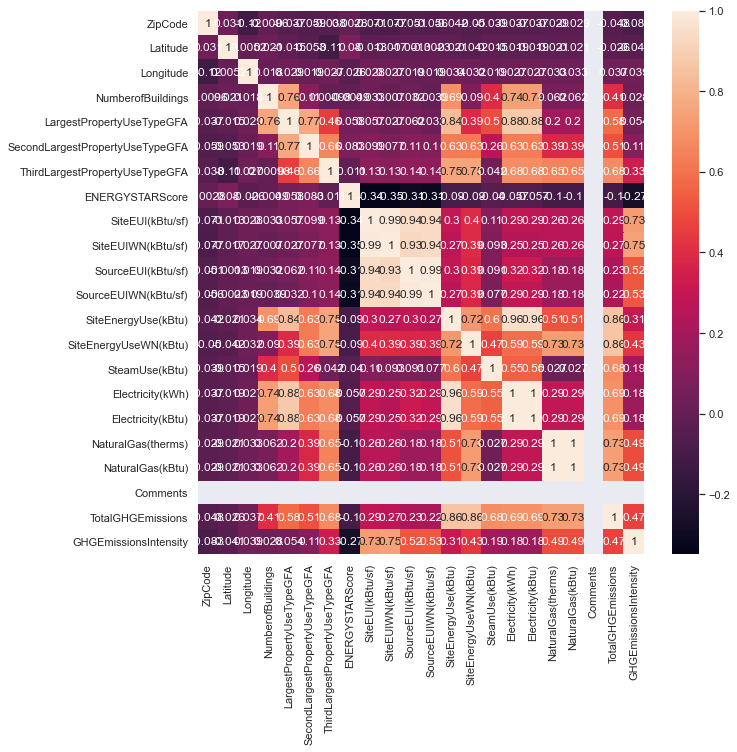

In [92]:
plt.figure(figsize=(10,10))
sns.heatmap(
    data.select_dtypes(include=['float64']).corr()
)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [78]:
data.GHGEmissionsIntensity.nunique()               

511